# Can 1s and 7s be distinguished by the angle of the single ellipse?

**Methods:**
>1. Load data
>2. Get ellipses for 1s and 7s
>3. Calculate dummy variable for 1s and see the fraction of misclassified 7s
>4. Calculate the angle of ellipse for 1s and 7s
>5. Plot a distribution of angles for 1s and 7s
>6. Create a dummy variable that includes this angle

**Results:**
>1. Done
>2. Done
>3. There are still ~10.5% of 7s and 7.8% of 4s classified as 1s by this dummy variable
>4. Done
>5. There isn't a good separation between 1s and 7s (or 4s) by the ellipse angle

**Conclusions:**
* The angle is not a good discriminator on its own

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.svm as skl_svm
import sklearn.cross_validation as skl_cv
import seaborn as sns
sns.set_context(context = 'notebook', font_scale=1.5)
import os
import sys
import cv2

base_path = '/home/lundi/Python/MNIST/'
sys.path.append(base_path + '/libraries/')

import MNIST_data_processor as mdp

MNIST_data_processor = mdp.MNIST_data_processor()

from matplotlib.patches import Ellipse

## 1. Load data

In [2]:
X, y = MNIST_data_processor.load_subset_data()

## Functions

In [3]:
def convert_to_image(data):
    img = np.zeros((28, 28,3))
    img[:,:,0] = data.reshape(28,28)
    img[:,:,1] = data.reshape(28,28)
    img[:,:,2] = data.reshape(28,28)
    
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img

def get_distance_between_ellipses(ellipse_1, ellipse_2):
    return np.sqrt(((ellipse_1[0][0] - ellipse_2[0][0]) ** 2) + ((ellipse_1[0][1] - ellipse_2[0][1]) ** 2))

def get_valid_contours(digit_data):
    image = convert_to_image(digit_data)
    
    ret,thresh = cv2.threshold(image,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)

    valid_contours = []
    #Get the valid contours
    for cnt in contours:
        if len(cnt) >= 5:
            valid_contours.append(cnt)
    return valid_contours

def get_aspect_ratio(ellipse):
    aspect_ratio = ellipse[1][1] / ellipse[1][0]
    return aspect_ratio

def get_aspect_ratio_of_single_ellipses(digit_data):
    
    valid_contours = get_valid_contours(digit_data)
    
    if len(valid_contours) == 1:
        ellipse_1 = cv2.fitEllipse(valid_contours[0])
                        
        return get_aspect_ratio(ellipse_1)
    else:
        return -1

## 2. Get ellipses for 1s and 7s

In [4]:
result_data = pd.concat([X.apply(get_aspect_ratio_of_single_ellipses, axis=1), y], axis=1).replace(-1, np.nan).dropna()
result_data = result_data.rename(columns = {0: 'aspect_ratio'})

## 3. Calculate dummy variable for 1s and see the fraction of misclassified 7s

In [8]:
result_data['classify_1'] = result_data['aspect_ratio'] > 3.6
result_data.groupby(['label'])['classify_1'].mean()

label
0    0.000000
1    0.886076
2    0.005848
3    0.000000
4    0.078125
5    0.004819
6    0.000000
7    0.105578
8    0.000000
9    0.000000
Name: classify_1, dtype: float64

#### There are still ~10.5% of 7s and 7.8% of 4s classified as 1s by this dummy variable

## 4. Calculate the angle of ellipse for 1s and 7s

In [9]:
def get_angle_of_single_ellipses(digit_data):
    
    valid_contours = get_valid_contours(digit_data)
    
    if len(valid_contours) == 1:
        ellipse_1 = cv2.fitEllipse(valid_contours[0])
                        
        return ellipse_1[2]
    else:
        return -1

In [10]:
result_data = pd.concat([X.apply(get_angle_of_single_ellipses, axis=1), y], axis=1).replace(-1, np.nan).dropna()
result_data = result_data.rename(columns = {0: 'angle'})

(-60, 360)

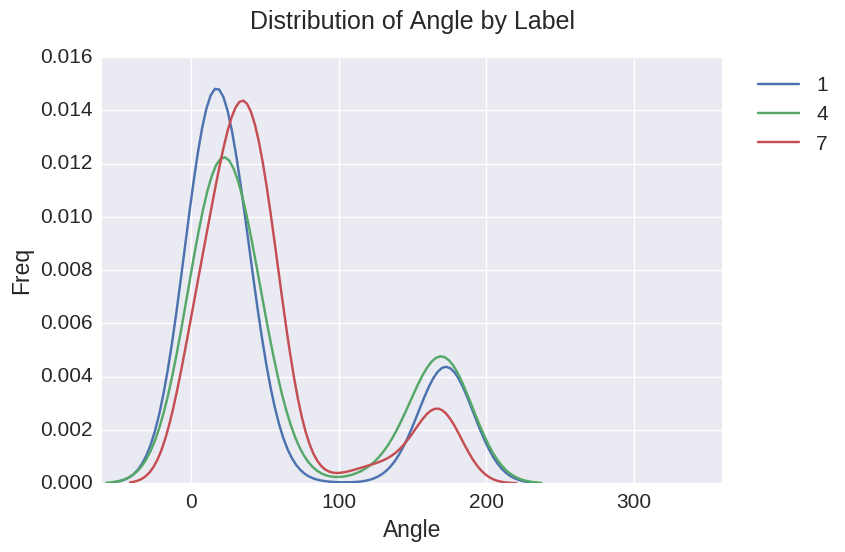

In [16]:
for label_index in [1,4,7]: 
    label_data = result_data.loc[result_data['label'] == label_index, 'angle']
    
    sns.kdeplot(label_data, label = str(label_index))
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.2,1))
ax.set_xlabel('Angle')
ax.set_ylabel('Freq')
ax.set_title('Distribution of Angle by Label', y=1.05)
ax.set_xlim([-60,360])
#ax.axvline(3.6)

## 5. Plot a distribution of angles for 1s and 7s

## 6. Create a dummy variable that includes this angle